In [80]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import pytorch_lightning as pl
from sklearn.mixture import GaussianMixture
from pytorch_forecasting import TimeSeriesDataSet, TemporalFusionTransformer
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorch_lightning import Trainer

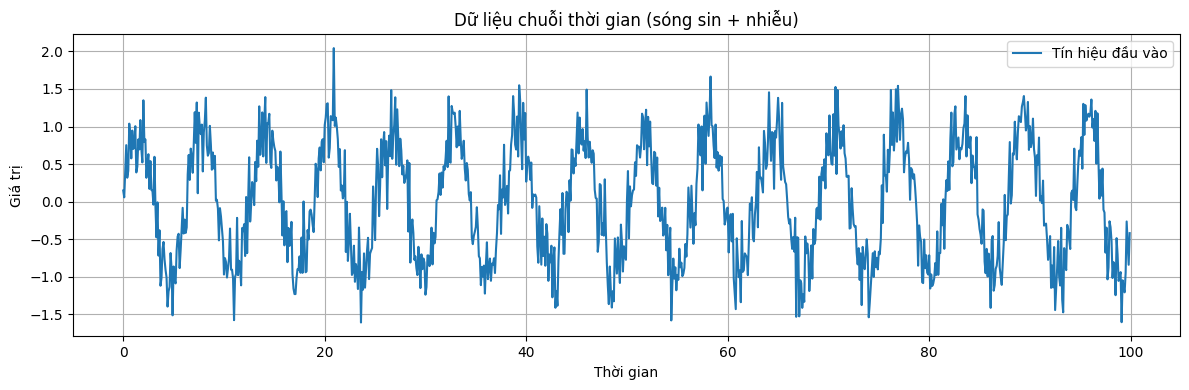

In [81]:
import numpy as np
import matplotlib.pyplot as plt

# Tạo dữ liệu sin + nhiễu
np.random.seed(42)
t = np.arange(0, 100, 0.1)
signal = np.sin(t) + np.random.normal(0, 0.3, len(t))

# Vẽ dữ liệu
plt.figure(figsize=(12, 4))
plt.plot(t, signal, label="Tín hiệu đầu vào")
plt.title("Dữ liệu chuỗi thời gian (sóng sin + nhiễu)")
plt.xlabel("Thời gian")
plt.ylabel("Giá trị")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [82]:
from sklearn.mixture import GaussianMixture

X = signal.reshape(-1, 1)
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_features = gmm.fit_predict(X)
gmm_probs = gmm.predict_proba(X)  # Đặc trưng dùng cho Transformer

In [83]:
import torch
from torch.utils.data import DataLoader, TensorDataset

window_size = 20
X_seq, y_seq = [], []

for i in range(len(gmm_probs) - window_size - 1):
    X_seq.append(gmm_probs[i:i+window_size])
    y_seq.append(signal[i+window_size])

X_tensor = torch.tensor(X_seq, dtype=torch.float32)
y_tensor = torch.tensor(y_seq, dtype=torch.float32).unsqueeze(1)

dataset = TensorDataset(X_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [84]:
from torch import nn

class SimpleTransformer(nn.Module):
    def __init__(self, input_dim, d_model=32, nhead=4, num_layers=2):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead, batch_first=True)
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        self.fc = nn.Linear(d_model, 1)

    def forward(self, x):
        x = self.embedding(x)          # [batch, seq_len, d_model]
        x = self.transformer(x)        # [batch, seq_len, d_model]
        x = x[:, -1, :]                # lấy bước thời gian cuối
        return self.fc(x)


In [85]:
model = SimpleTransformer(input_dim=3)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

losses = []
for epoch in range(10):
    total_loss = 0
    for xb, yb in dataloader:
        optimizer.zero_grad()
        pred = model(xb)
        loss = criterion(pred, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    losses.append(total_loss / len(dataloader))
    print(f"Epoch {epoch+1}, Loss: {losses[-1]:.4f}")


Epoch 1, Loss: 0.4011
Epoch 2, Loss: 0.1675
Epoch 3, Loss: 0.1604
Epoch 4, Loss: 0.1485
Epoch 5, Loss: 0.1569
Epoch 6, Loss: 0.1368
Epoch 7, Loss: 0.1370
Epoch 8, Loss: 0.1375
Epoch 9, Loss: 0.1373
Epoch 10, Loss: 0.1457


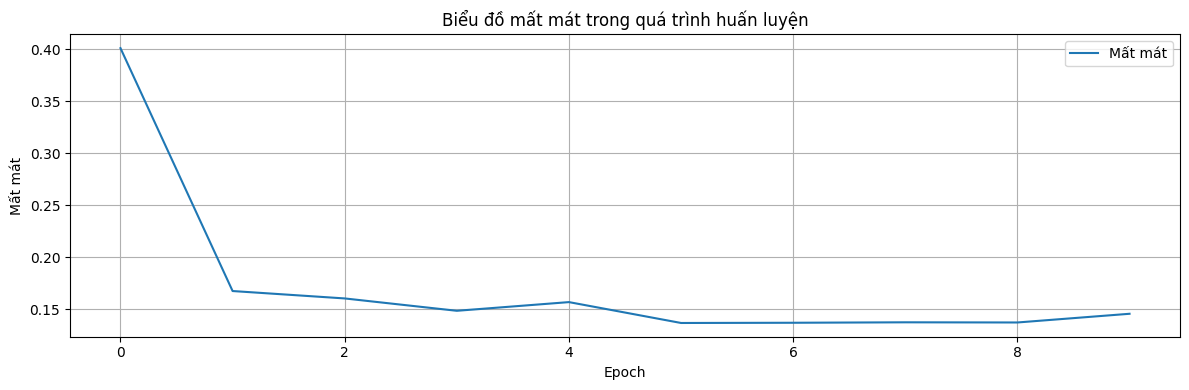

In [86]:
# Vẽ biểu đồ mất mát
plt.figure(figsize=(12, 4))
plt.plot(losses, label="Mất mát")
plt.title("Biểu đồ mất mát trong quá trình huấn luyện")
plt.xlabel("Epoch")
plt.ylabel("Mất mát")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
